In [1]:
import json
import torch
from torch.utils.data import DataLoader, random_split
import segmentation_models_pytorch as smp
from utils.dataset import TrainDataset
from utils import visualization

In [2]:
MODEL_CONFIG = 'Synthetic+Manual.json'
with open(f"./model configs/{MODEL_CONFIG}") as f:
    model_config = json.load(f)
print(model_config)

{'config name': 'Synthetic+Manual.pt', 'train sets': ['./datasets/new_blender_dataset/Config1', './datasets/new_blender_dataset/Config2', './datasets/new_blender_dataset/Config3', './datasets/new_blender_dataset/Config4', './datasets/manual_dataset/one/', './datasets/manual_dataset/two/', './datasets/manual_dataset/three/'], 'weight name': 'Synthetic+Manual.pt'}


In [3]:
# create segmentation model with pretrained encoder
model = smp.UnetPlusPlus(
    encoder_name='se_resnext50_32x4d', 
    encoder_weights='imagenet',
    activation='sigmoid'
)

In [4]:
# dataset paths
dataset_paths = model_config['train sets']

In [5]:
dataset = TrainDataset(dataset_paths)
print(f"total: {len(dataset)}")
train_dataset, valid_dataset = random_split(dataset, [0.8, 0.2])
print(f"train: {len(train_dataset)}")
print(f"valid: {len(valid_dataset)}")

total: 1080
train: 864
valid: 216


input:	 torch.Size([1, 3, 320, 480])
output:	 torch.Size([1, 1, 320, 480])
tensor([[[0.4588, 0.5020, 0.4627,  ..., 0.2902, 0.2784, 0.3529],
         [0.4431, 0.4392, 0.5412,  ..., 0.2784, 0.2588, 0.3373],
         [0.4980, 0.4588, 0.5294,  ..., 0.3294, 0.2392, 0.2235],
         ...,
         [0.3882, 0.4118, 0.5451,  ..., 0.5216, 0.4510, 0.4235],
         [0.3333, 0.3098, 0.3451,  ..., 0.5451, 0.5294, 0.4784],
         [0.3882, 0.3255, 0.3765,  ..., 0.6157, 0.5725, 0.4863]],

        [[0.4588, 0.4863, 0.4902,  ..., 0.3176, 0.3098, 0.3804],
         [0.4863, 0.4549, 0.5216,  ..., 0.2941, 0.2902, 0.3608],
         [0.5412, 0.5373, 0.5529,  ..., 0.3490, 0.2471, 0.2392],
         ...,
         [0.3922, 0.4196, 0.5647,  ..., 0.4863, 0.4275, 0.3961],
         [0.3765, 0.3373, 0.3804,  ..., 0.5216, 0.5059, 0.4824],
         [0.4353, 0.3647, 0.3882,  ..., 0.6078, 0.5725, 0.5059]],

        [[0.4392, 0.5137, 0.4941,  ..., 0.3020, 0.3137, 0.3725],
         [0.4706, 0.4392, 0.5373,  ..., 0.3098, 

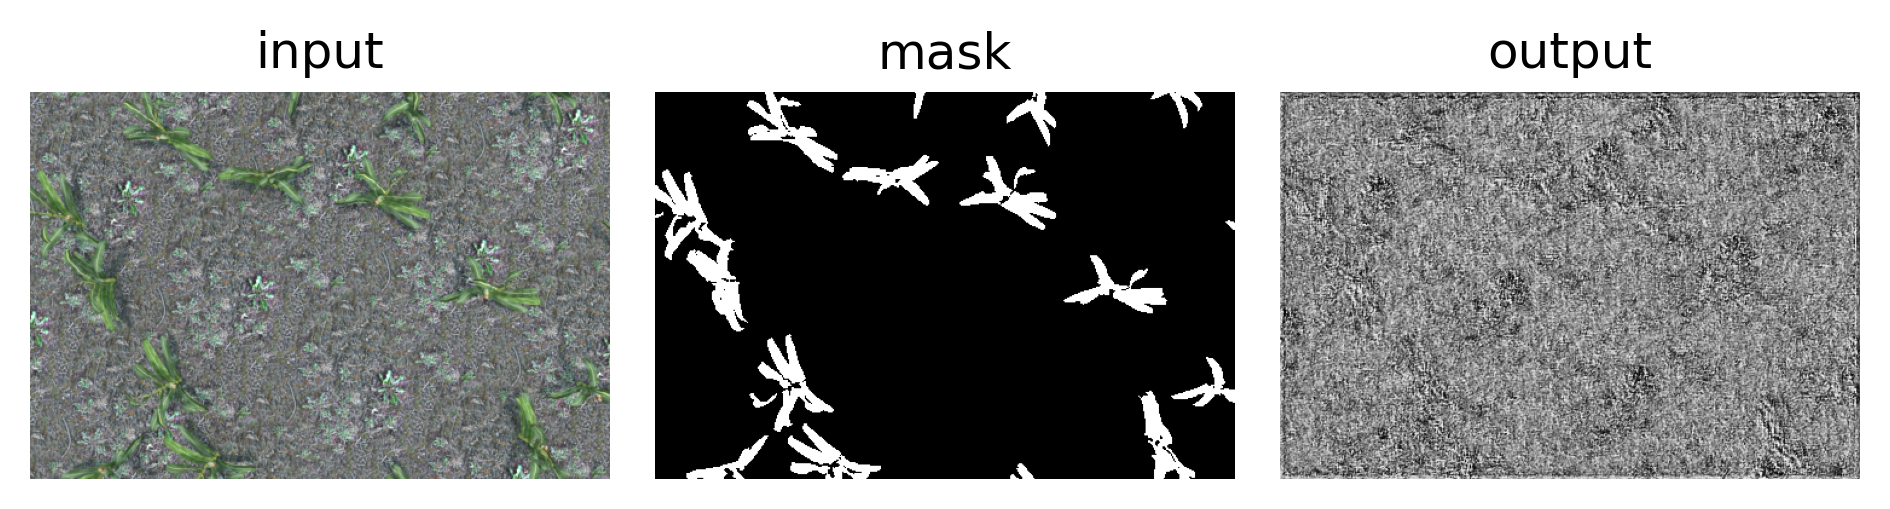

In [6]:
input_image, mask = dataset[0]
input = torch.unsqueeze(input_image, 0)
output = model(input)
output_image = output[0]

print('input:\t', input.shape)
print('output:\t', output.shape)
print(input_image)
print(mask)
visualization.show_image_list(
    images=[input_image, mask, output_image],
    titles=["input", "mask", "output"]
)

In [7]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=4
)

valid_loader = DataLoader(
    dataset=train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=4
)

In [8]:
from segmentation_models_pytorch.utils.metrics import IoU
from segmentation_models_pytorch.utils.losses import DiceLoss

DEVICE = 'cuda'
loss = DiceLoss()

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00008),
])

metrics = [
    IoU(threshold=0.5),
]

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [9]:
torch.cuda.empty_cache()

In [10]:
# torch.save(model, './weights/never_trained.pth')

In [11]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(
    log_dir='logs/',
)

epoch_num = 20
for epoch in range(epoch_num):
    print(f"Epoch {epoch+1}")
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    torch.save(model, f'./weights/{model_config["weight name"]}_{epoch+1}.pth')
    writer.add_scalar("train/loss", train_logs[loss.__name__] , epoch+1)
    writer.add_scalar("train/iou", train_logs['iou_score'] , epoch+1)
    writer.add_scalar("valid/loss", valid_logs[loss.__name__] , epoch+1)
    writer.add_scalar("valid/iou", valid_logs['iou_score'] , epoch+1)
        


Epoch 1
train:   0%|          | 0/108 [00:00<?, ?it/s]

valid: 100%|██████████| 108/108 [00:07<00:00, 14.26it/s, dice_loss - 0.4252, iou_score - 0.6871]
Epoch 2
valid: 100%|██████████| 108/108 [00:07<00:00, 14.25it/s, dice_loss - 0.3291, iou_score - 0.7421]
Epoch 3
valid: 100%|██████████| 108/108 [00:07<00:00, 14.29it/s, dice_loss - 0.2771, iou_score - 0.7581]
Epoch 4
valid: 100%|██████████| 108/108 [00:07<00:00, 14.20it/s, dice_loss - 0.2229, iou_score - 0.8084]
Epoch 5
valid: 100%|██████████| 108/108 [00:07<00:00, 14.33it/s, dice_loss - 0.197, iou_score - 0.8138] 
Epoch 6
valid: 100%|██████████| 108/108 [00:07<00:00, 14.39it/s, dice_loss - 0.156, iou_score - 0.8345] 
Epoch 7
valid: 100%|██████████| 108/108 [00:07<00:00, 14.28it/s, dice_loss - 0.1387, iou_score - 0.8321]
Epoch 8
valid: 100%|██████████| 108/108 [00:07<00:00, 14.25it/s, dice_loss - 0.1266, iou_score - 0.8396]
Epoch 9
valid: 100%|██████████| 108/108 [00:07<00:00, 14.23it/s, dice_loss - 0.1172, iou_score - 0.8443]
Epoch 10
valid: 100%|██████████| 108/108 [00:07<00:00, 14.26it/